In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from ipywidgets import interact, Dropdown
import pandas as pd
import numpy as np
import tarfile
import trec
import pprint
import json
import copy
# https://wiki.python.org/moin/UsingPickle
import pickle
import re

pp = pprint.PrettyPrinter(width=120, compact=True)

# Load Patient Case Descriptions

In [2]:
Queries = "topics-2014_2015-summary.topics"
Qrels = "qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)
cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

eval = trec.TrecEvaluation(cases, Qrels)


In [ ]:
pp.pprint(cases)

# Loading stop words file

In [3]:
gist_file = open("stopWords.txt", "r")
try:
    content = gist_file.read()
    stop_words = content.split(",")
finally:
    gist_file.close()


# Define Clinical Trial Document Structure

In [4]:

class Trial:
    _nct_id : str
    _brief_title : str
    _detailed_description : str
    _brief_summary : str
    _criteria : str
    _phase : str
    _study_type : str
    _study_design : str
    _condition : str
    _intervention : {}
    _gender : str
    _min_age : int
    _max_age : int
    _healthy_volunteers : str
    _mesh_terms : []

    def __init__(self):
        self._nct_id = ""
        self._intervention = {}
        self._mesh_terms = []

    def show(self):
        print(json.dumps(self.__dict__, indent=4))

def cleanstr(txt):
    return re.sub(' +', ' ', txt.strip().replace('\n',''))


# Load the clinical trials

In [ ]:
tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
i = 0
ids = []
full_docs = []
for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True

        if judged is False:
            continue

        i = i + 1

        trial = Trial()
        
        for brief_title in root.iter('brief_title'):
            ids.append(doc_id.text)
            trial._nct_id = cleanstr(doc_id.text)
            trial._brief_title = cleanstr(brief_title.text)

        trial._detailed_description = trial._brief_title
        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                trial._detailed_description = cleanstr(child.text)

        trial._brief_summary = trial._brief_title
        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                trial._brief_summary = cleanstr(child.text)

        trial._criteria = trial._brief_title
        for criteria in root.iter('criteria'):
            for child in criteria:
                trial._criteria = cleanstr(child.text)
                
        trial._phase = trial._brief_title
        for phase in root.iter('phase'):
            trial._phase = cleanstr(phase.text)

        for study_type in root.iter('study_type'):
            trial._study_type = cleanstr(study_type.text)
            
        for study_design in root.iter('study_design'):
            trial._study_design = cleanstr(study_design.text)
            
        trial._condition = trial._brief_title
        for condition in root.iter('condition'):
            trial._condition = cleanstr(condition.text)

        for interventions in root.iter('intervention'):
            for child in interventions:
                trial._intervention[cleanstr(child.tag)] = cleanstr(child.text)

        trial._gender = "both"
        for gender in root.iter('gender'):
            trial._gender = cleanstr(gender.text)
            
        trial._minimum_age = 0
        for minimum_age in root.iter('minimum_age'):
            age = re.findall('[0-9]+', cleanstr(minimum_age.text))
            if age:
                trial._minimum_age = int(age[0])
            else:
                trial._minimum_age = 0
            
        trial._maximum_age = 150
        for maximum_age in root.iter('maximum_age'):
            age = re.findall('[0-9]+', cleanstr(maximum_age.text))
            if age:
                trial._maximum_age = int(age[0])
            else:
                trial._maximum_age = 150
               
            
        trial._healthy_volunteers = trial._brief_title
        for healthy_volunteers in root.iter('healthy_volunteers'):
            trial._healthy_volunteers = cleanstr(healthy_volunteers.text)
            
        for mesh_term in root.iter('mesh_term'):
            trial._mesh_terms.append(cleanstr(mesh_term.text))
        
        full_docs.append(trial)
        
tar.close()

print("Total of clinical trials: ", i)

pickle.dump(ids, open( "doc_ids.bin", "wb" ) )
pickle.dump(full_docs, open( "full_documents.bin", "wb" ) )


In [ ]:
# Example of a document
pp.pprint(vars(full_docs[0]))

# Retrieval Models

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix

class VSMindex:
    def __init__(self, corpus, _ngram_range=(1, 1), _analyzer='word', _stop_words=None):
        self.vectorizer = TfidfVectorizer(ngram_range=_ngram_range, analyzer=_analyzer, stop_words=_stop_words)
        self.count_matrix = self.vectorizer.fit_transform(corpus)

    def search(self, query):
        query_vector = self.vectorizer.transform([query])
        doc_scores = (1 - pairwise_distances(query_vector, self.count_matrix, metric='cosine')).flatten()
    
        return doc_scores


class LMJMindex:
    
    def __init__(self, corpus, _ngram_range=(1,1), _analyzer='word', _stop_words=None):
        self.vectorizer = CountVectorizer(ngram_range=_ngram_range, analyzer=_analyzer, stop_words=_stop_words)
        self.count_matrix = self.vectorizer.fit_transform(corpus)
        
        term_freq = np.sum(self.count_matrix, axis=0)

        doc_len = np.sum(self.count_matrix, axis=1) 

        self.prob_term_col = term_freq / np.sum(term_freq)

        self.prob_term_doc = self.count_matrix / doc_len
        
        # Set initial lambda value     
        params = {'lambda' : 0.3}
        self.set_params(params)

        
    def set_params(self, params):
        if 'lambda' in params:
            self.lbd = params['lambda']
            self._log_lmjm = np.log(self.lbd * self.prob_term_doc + (1 - self.lbd) * self.prob_term_col)
            print("LMJM lambda ", self.lbd)

            
    def search(self, query):
        query_vector = self.vectorizer.transform([query])

        #prob_term_query = query_vector / np.sum(query_vector)

        # np.array is used with flatten so instead of the operation resulting in a nx1 matrix it results in an array
        doc_scores = np.array(np.sum(query_vector.multiply(self._log_lmjm), axis=1)).flatten()

        return doc_scores

# LETOR Model

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

class LETORindex:
    
    def __init__(self, name, model, dataset, model_number):
        self.name = name
        self.model = model
        self.dataset = dataset
        self.model_number = model_number
        
        test_queries = [20155, 201514, 20152, 201512, 201524, 20154, 201423, 201429, 201413, 20144]
        
        training_dataset, test_dataset = self.split_dataset_on_queries(self.dataset, test_queries)
            
        X_train, y_train = self.get_X_scaled_and_y(training_dataset)
        self.X_test, self.y_test = self.get_X_scaled_and_y(test_dataset)
            
        self.y_test = self.y_test.replace(2,1)
        
        # Model 4 - Weight each sample differently, according to the class importance
        if self.model_number == 4:      
            if self.name == "judged":  
                w2 = 0.4
                w1 = 0.2
                w0 = 0.1
                 
            elif self.name == "non_judged":
                w2 = 40
                w1 = 20
                w0 = 1
                    
            else:
                w2 = 0.2
                w1 = 0.1
                w0 = 10
                 
            weights = {0.0: w0, 1.0: w1, 2.0: w2}

            sample_weight = y_train.map(weights)
            y_train = y_train.replace(2,1) 
                
            self.model.fit(X_train, y_train, sample_weight=sample_weight)
                               
        else:
            y_train = y_train.replace(2,1)
            self.model.fit(X_train, y_train)            
        
        
    def split_dataset_on_queries(self, dataset, queries):
        # Training dataset, filters rows that do not have test_queries
        train_dataset = dataset[~dataset['case_id'].isin(queries)]

        #train_dataset.to_csv(f"train {name}.csv", index=False)

        # Test dataset, filters rows with test_queries
        test_dataset = dataset[dataset['case_id'].isin(queries)]

        #test_dataset.to_csv(f"test {name}.csv", index=False)
        
        return train_dataset, test_dataset
    
    
    def get_X_scaled_and_y(self, dataset):
        X = dataset.drop(columns=['case_id', 'doc_id','y'])

        scaler = StandardScaler()
        scaler.fit(X)

        X_scaled = scaler.transform(X)
        y = dataset["y"]
        
        return X_scaled, y
                                                                
        
    def show_model_metrics(self):
        y_pred = self.model.predict(self.X_test)
        y_pred_prob = self.model.predict_proba(self.X_test)[:,1]
        
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        precision = precision_score(self.y_test, y_pred, zero_division=0)
        print(f"Precision: {precision:.4f}")
        recall = recall_score(self.y_test, y_pred)
        print(f"Recall: {recall:.4f}")
        mse = mean_squared_error(self.y_test, y_pred)
        print(f"MSE: {mse:.4f}")
        """f1 = f1_score(self.y_test, y_pred)
        print(f"F1 Score: {f1:.4f}")
        auc = roc_auc_score(self.y_test, y_pred_prob)
        print(f"AUC Score: {auc:.4f}")
        mcc = matthews_corrcoef(self.y_test, y_pred)
        print(f"Matthews Correlation Coefficient: {mcc:.4f}")"""
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        plt.figure(figsize=(4, 3))

        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=True)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

            
    def search(self, query):
        doc_scores = np.array(0)
        index_names = dataset.drop(columns=['case_id', 'doc_id','y']).columns.tolist()
        coefs = self.model.coef_[0]
        
        for c, index in zip(coefs, index_names):
            scaler = StandardScaler()
            index_column = self.dataset[index] 
            scaler.fit(np.reshape(index_column, (-1, 1)))
                
            search = scaler.transform(np.reshape(indexes_list[index].search(query), (-1, 1)))
                
            doc_scores = doc_scores + c * search

        
        return doc_scores
       
    
    def compute_ranking(self, create_csv=True): 
        X_scaled, y = self.get_X_scaled_and_y(self.dataset)

        coefficients = self.model.coef_[0]

        weighted_sums = X_scaled.dot(coefficients.T)

        # Rank documents based on the weighted sums
        result_df = pd.DataFrame({'case_id': self.dataset.case_id, 'doc_id': self.dataset.doc_id, 'Score': weighted_sums, 'Label': y})
        

        # If it is the model with duplicated dataset
        if self.model_number == 3:
            # Average the score of duplicate rows and merge them
            result_df = result_df.groupby(['case_id', 'doc_id'], as_index=False).agg({'Score': 'mean', 'Label': 'first'})

        # Sort the DataFrame by scores in descending order
        result_df = result_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

        if create_csv:
            result_df.to_csv(f"{self.name}_ranking_{self.model_number}.csv", index=False)
        
        return result_df  

In [10]:
from itertools import product
index1 = cases.keys()
index2 = ids

combinations = list(product(index1, index2))

multi_index = pd.MultiIndex.from_tuples(combinations, names=['case_id', 'doc_id'])


# Create dataset with doc scores for a given patient description in all clinical trials across all indexes
doc_scores_df = pd.DataFrame(index=multi_index, columns=list(indexes_list.keys()))

for index_name, index in indexes_list.items():
    if "full" in index_name or  index_name in indexes:
        doc_scores_df.drop(index_name, axis=1, inplace=True)
        
    else:
        total_scores = []
        for caseid in cases:
            doc_scores = index.doc_scores[caseid] 
            total_scores.extend(doc_scores)

        doc_scores_df[index_name] = total_scores
        
doc_scores_df.to_csv("doc_scores.csv", index=True)

# Create dataset from text file with y values (relevant or non relevant) for each query/document pair
relevancy_df = pd.read_csv('qrels-clinical_trials.txt', 
                           delim_whitespace=True, 
                           names=['case_id', 'x', 'doc_id','y'], 
                           dtype={'case_id': object}).drop('x', axis=1)

relevancy_df.to_csv("relevancy.csv", index=False)

# Merge dataset with text file for y values (relevant or non relevant) for each query/document pair
merged_df = doc_scores_df.merge(relevancy_df, on=['case_id', 'doc_id'], how='left')

# Option a): Judged only documents
merged_df.dropna().to_csv("judged_only.csv", index=False)

# Option b): With non-judged documents (Replace NaN values with 0)
merged_df.fillna(0, inplace=False).to_csv("non_judged.csv", index=False)

# Option c): Hard negatives
#-------------------------------------------

Load from csvs

In [10]:
datasets = {}
datasets["judged"] = pd.read_csv("judged_only.csv")
datasets["non_judged"] = pd.read_csv("non_judged.csv")
datasets["hard_negatives"] = pd.read_csv("hard_negatives.csv")

#judged_df = pd.read_csv("judged_only.csv", index_col=0) # index_col=0 to restore original index

#non_judged_df = pd.read_csv("non_judged.csv", index_col=0)

#hard_negatives_df = pd.read("hard_negatives.csv", index_col=0)
#for df in datasets:
#    print(datasets[df])

# Indexing

In [8]:
import pickle
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )

corpus_brief_title = []
corpus_brief_summary = []
corpus_detailed_description = []
corpus_criteria = []
corpus_full = []
for trial in full_docs:
    corpus_brief_title.append(trial._brief_title)
    corpus_brief_summary.append(trial._brief_summary)
    corpus_detailed_description.append(trial._detailed_description)
    corpus_criteria.append(trial._criteria)

    full = trial._brief_title + trial._brief_summary + trial._detailed_description + trial._criteria
    corpus_full.append(full)

indexes_list = {}

indexes_list['vsm_brief_title'] = VSMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_brief_summary'] = VSMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_detailed_description'] = VSMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_criteria'] = VSMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_full'] = VSMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)

indexes_list['lmjm_brief_title'] = LMJMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_brief_summary'] = LMJMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_detailed_description'] = LMJMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_criteria'] = LMJMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_full'] = LMJMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)

# pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )


C:\Users\nmnog\anaconda3\envs\nlp-cv-ir\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


LMJM lambda  0.3
LMJM lambda  0.3


C:\Users\nmnog\anaconda3\envs\nlp-cv-ir\lib\site-packages\scipy\sparse\_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


LMJM lambda  0.3
LMJM lambda  0.3
LMJM lambda  0.3


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

C = 0.5
for name in datasets:
    dataset = datasets[name]

    # Separate rows by label
    label_0 = dataset[dataset["y"] == 0]
    label_1 = dataset[dataset["y"] == 1]
    label_2 = dataset[dataset["y"] == 2]
        
    # Count the number of each label
    count_label_0 = len(label_0)
    count_label_1 = len(label_1)
    count_label_2 = len(label_2)
    
    if name == "hard_negatives":
        # FOR MODEL 3 (# Model 3 - Repeat the query-document pairs to balance data and shuffle data)
        
        # Calculate the number of duplications needed
        label_0_dupes_needed = int(count_label_1 + count_label_2 - count_label_0)

        # Duplicate rows of label 0 to match the count of labels 1 and 2 combined
        label_0_duplicated = label_0.sample(n=label_0_dupes_needed, replace=True, random_state=42)

        # Concatenate the duplicated rows with their original counterparts
        dataset_balanced = pd.concat([label_0, label_1, label_2, label_0_duplicated])
        
    else:
        # FOR MODEL 3 (# Model 3 - Repeat the query-document pairs to balance data and shuffle data)   

        # Calculate the number of duplications needed
        label_1_dupes_needed = int(count_label_0/2 - count_label_1)
        label_2_dupes_needed = int(count_label_0/2 - count_label_2)

        # Duplicate rows of label 1 and 2 to match the count of label 0
        label_1_duplicated = label_1.sample(n=label_1_dupes_needed, replace=True, random_state=42)
        label_2_duplicated = label_2.sample(n=label_2_dupes_needed, replace=True, random_state=42)

        # Concatenate the duplicated rows with their original counterparts
        dataset_balanced = pd.concat([label_0, label_1, label_1_duplicated, label_2, label_2_duplicated])

    # Shuffle the DataFrame to mix the rows
    dataset_balanced = dataset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(dataset_balanced["y"].value_counts())
    # Save to csv
    dataset_balanced.to_csv(f"model_3_{name}.csv", index=False)


    model_info = [] # (Model, dataset, model_number)

    model_info.append((LogisticRegression(C=C, max_iter=1000), dataset, 1)) # Model 1 - Without correction
    model_info.append((LogisticRegression(C=C, class_weight='balanced', max_iter=1000), dataset, 2)) # Model 2 - Equal weights per class
    model_info.append((LogisticRegression(C=C, max_iter=1000), dataset_balanced, 3)) # Model 3 - Repeat the query-document pairs to balance data and shuffle data
    model_info.append((LogisticRegression(C=C, max_iter=1000), dataset, 4)) # Model 4 - Weight each sample differently, according to the class importance

    for model, dataset, model_number in model_info:
        indexes_list[f'{name}_model_{model_number}'] = LETORindex(name, model, dataset, model_number)

y
0.0    2764
1.0    1382
2.0    1382
Name: count, dtype: int64
y
0.0    212828
1.0    106414
2.0    106414
Name: count, dtype: int64
y
0.0    1106
1.0     685
2.0     421
Name: count, dtype: int64


In [12]:
indexes_list["hard_negatives_model_3"].compute_ranking(create_csv=False)

,case_id,doc_id,Score,Label
0,201517,NCT00736216,11.709810,1.0
1,201424,NCT02232191,10.814253,2.0
2,201411,NCT00382421,10.506011,1.0
3,201412,NCT00715572,10.285679,2.0
4,201411,NCT01296789,10.281565,1.0
...,...,...,...,...
1163,201425,NCT01942564,-5.571943,0.0
1164,201425,NCT01619943,-5.737325,0.0
1165,201425,NCT00451789,-5.784984,0.0
1166,201425,NCT01595906,-6.557163,0.0


Given an initial ranking with data preperation a) or b), create a df with high negatives and low positives

In [21]:
result_df = pd.read_csv("judged_ranking_3.csv") # Use ranking 3 from judged approach as it had the best metrics

# Extracting the first 100 rows
first_100_rows = result_df.head(100)

# Extracting rows with positive_label
label_1_rows = result_df[result_df['Label'] >= 1]

# Concatenating the first 100 rows and label 1 rows
combined_df = pd.concat([first_100_rows, label_1_rows])

# Dropping duplicates based on case_id column
new_df = combined_df.drop_duplicates(subset=['case_id', 'doc_id'])

new_df.reset_index(drop=True, inplace=True)

# Merge dataset with text file for y values (relevant or non relevant) for each query/document pair
judged_df = pd.read_csv("judged_only.csv")
new_df = new_df.merge(judged_df, on=['case_id', 'doc_id']).drop(columns=["Score", "Label"])

# Shuffle the DataFrame to mix the rows
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(new_df["y"].value_counts())
new_df.to_csv("hard_negatives.csv", index=False)

y
1.0    685
2.0    421
0.0     62
Name: count, dtype: int64


### Helper code to calibrate parameters

In [ ]:
import trec
params = {}
avg_precision_11point = np.zeros(11)
for lbd in [0, 0.05, 0.1, 0.3, 0.5, 0.6, 0.8, 0.9]:
    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    index = indexes_list['lmjm_full']
    params['lambda'] = lbd
    index.set_params(params)
    for caseid in cases:
        query = cases[caseid]
        doc_scores = index.search(query)

        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)
        #print(doc_scores)
        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall
    
    m_ap = m_ap / len(cases)
    m_p10 = m_p10 / len(cases)
    m_mrr = m_mrr / len(cases)
    m_ndcg5 = m_ndcg5 / len(cases)
    m_recall = m_recall / len(cases)
    print("   MAP    ", m_ap)
    print("   MRR    ", m_mrr)
    print("   P10    ", m_p10)
    print("   NDCG@5 ", m_ndcg5)
    print("   Recall ", m_recall)



# Retrieval

In [11]:
for index_name in indexes_list:
    print()
    print(index_name)
    index = indexes_list[index_name]
    index.doc_scores = {}
    index.results_ord = {}
    for caseid in cases:
        query = cases[caseid]

        doc_scores = index.search(query)

        index.doc_scores[caseid] = doc_scores
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        index.results_ord[caseid] = results.sort_values(by=['score'], ascending = False)

    indexes_list[index_name] = index

#pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )


vsm_brief_title


C:\Users\nmnog\anaconda3\envs\nlp-cv-ir\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(



vsm_brief_summary

vsm_detailed_description

vsm_criteria

vsm_full

lmjm_brief_title

lmjm_brief_summary

lmjm_detailed_description

lmjm_criteria

lmjm_full

judged_model_1

judged_model_2

judged_model_3

judged_model_4

non_judged_model_1

non_judged_model_2

non_judged_model_3

non_judged_model_4

hard_negatives_model_1

hard_negatives_model_2

hard_negatives_model_3

hard_negatives_model_4


LETOR Model only (does retrieval for individual models also)

In [14]:
pass_indexes = ['vsm_brief_title', 'vsm_brief_summary', 'vsm_detailed_description', 'vsm_criteria', 'vsm_full', 'lmjm_brief_title', 'lmjm_brief_summary', 'lmjm_detailed_description', 'lmjm_criteria', 'lmjm_full']


for index_name in indexes_list:
    if index_name in pass_indexes:
        continue

    print()
    print(index_name)
    index = indexes_list[index_name]
    index.doc_scores = {}
    index.results_ord = {}
    for caseid in cases:
        query = cases[caseid]

        doc_scores = index.search(query)

        index.doc_scores[caseid] = doc_scores
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        index.results_ord[caseid] = results.sort_values(by=['score'], ascending = False)

    indexes_list[index_name] = index

#pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) 


judged_model_1

judged_model_2

judged_model_3

judged_model_4

non_judged_model_1

non_judged_model_2

non_judged_model_3

non_judged_model_4

hard_negatives_model_1

hard_negatives_model_2

hard_negatives_model_3

hard_negatives_model_4


## Filters

In [10]:
import re

def check_words_in_query(query, target_words):
    for target_word in target_words:
        pattern = re.compile(r'\b{}\b|\b{}-\b'.format(target_word, target_word), re.IGNORECASE)

        match = re.search(pattern, query)
        
        if bool(match):
            return True

    return False


def extract_age_and_gender(query):
    age_pattern = re.compile(r'\b(\d{1,3})\b(?: ?(?:-|years?-?)? ?(?:old|yo))?\b')
    gender_patterns = re.compile(r'\b(?:man|boy|male|woman|women|girl|female)\b', re.IGNORECASE)

    # Extract age
    default_age = 150
    age_match = age_pattern.search(query)
    # Check if the query contains relevant terms indicating age
    age_terms_present = check_words_in_query(query ,["year", "month", "yo"])
    
    if age_match and age_terms_present:        
        age_value = int(age_match.group(1))
        age = age_value / 12 if 'month' in query.lower() and 'year' not in query.lower() else age_value
        age = age if age_terms_present else default_age
        
    else:
        young_adult = check_words_in_query(query, ["young"])
        default_age = 21 if young_adult else default_age
        age = default_age

    # Extract gender
    default_gender = 'Unknown'
    gender_match = gender_patterns.search(query)
    gender = gender_match.group(0).lower() if gender_match else default_gender

    # Standardize gender
    if gender in ['man', 'boy', 'male']:
        gender = 'Male'
    elif gender in ['woman', 'women', 'girl', 'female']:
        gender = 'Female'    
    

    return age, gender


test = False

def filter_by_age_and_gender(doc_scores, query):
    
    age, gender = extract_age_and_gender(query)
    
    filtered_ids = []
    for i in range(len(full_docs)):
        pp.pprint(vars(full_docs[i])['_nct_id'])
    
    for i in range(len(full_docs)):
        trial = vars(full_docs[i])
        
        age_check = trial['_minimum_age'] <= age and age <= trial['_maximum_age']
        
        
        gender_check = trial['_gender'] == 'Both' or trial['_gender'] == gender
        
        # Filter unwanted documents
        # Filter document i (CHECK IF IT IS WORKING)
        if not (age_check and gender_check):
            doc_scores[query][i] = -1000000
    

    #return filtered_ids
    return doc_scores

------------------------------
# Compute evaluation metric results
For each patient, search each index and rank clinical trials by their similarity to the patient case description

In [ ]:
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )
indexes_list = pickle.load( open( "indexes_list.bin", "rb" ) )


In [ ]:
for index_name in indexes_list:
    index = indexes_list[index_name]
    print()
    print(index_name)

    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    mean_precision_11point = np.zeros(11)
    
    index.p10_per_query = {}
    index.ndcg5_per_query = {}
    index.recall_per_query = {}
    index.mrr_per_query = {}
    index.ap_per_query = {}
    index.precision_11point_per_query = {}

    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        #p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        if (np.shape(recall_11point) != (0,)):
            mean_precision_11point = mean_precision_11point + precision_11point
        
        index.p10_per_query[caseid] = p10
        index.ndcg5_per_query[caseid] = ndcg5
        index.recall_per_query[caseid] = recall
        index.mrr_per_query[caseid] = mrr
        index.ap_per_query[caseid] = ap
        index.precision_11point_per_query[caseid] = precision_11point

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall

    index.m_ap = m_ap / len(cases)
    index.m_p10 = m_p10 / len(cases)
    index.m_mrr = m_mrr / len(cases)
    index.m_ndcg5 = m_ndcg5 / len(cases)
    index.m_recall = m_recall / len(cases)
    index.mean_precision_11point = mean_precision_11point/len(cases)

    print("   P10    ", index.m_p10)
    print("   NDCG@5 ", index.m_ndcg5)
    print("   MRR    ", index.m_mrr)
    print("   MAP    ", index.m_ap)
    print("   Recall ", index.m_recall)

    indexes_list[index_name] = index

pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )


LETOR Model only

In [15]:
pass_indexes = ['vsm_brief_title', 'vsm_brief_summary', 'vsm_detailed_description', 'vsm_criteria', 'vsm_full', 'lmjm_brief_title', 'lmjm_brief_summary', 'lmjm_detailed_description', 'lmjm_criteria', 'lmjm_full']


for index_name in indexes_list:
    if index_name in pass_indexes:
        continue
    index = indexes_list[index_name]
    print()
    print(index_name)

    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    mean_precision_11point = np.zeros(11)
    
    index.p10_per_query = {}
    index.ndcg5_per_query = {}
    index.recall_per_query = {}
    index.mrr_per_query = {}
    index.ap_per_query = {}
    index.precision_11point_per_query = {}

    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        #p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        if (np.shape(recall_11point) != (0,)):
            mean_precision_11point = mean_precision_11point + precision_11point
        
        index.p10_per_query[caseid] = p10
        index.ndcg5_per_query[caseid] = ndcg5
        index.recall_per_query[caseid] = recall
        index.mrr_per_query[caseid] = mrr
        index.ap_per_query[caseid] = ap
        index.precision_11point_per_query[caseid] = precision_11point

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall

    index.m_ap = m_ap / len(cases)
    index.m_p10 = m_p10 / len(cases)
    index.m_mrr = m_mrr / len(cases)
    index.m_ndcg5 = m_ndcg5 / len(cases)
    index.m_recall = m_recall / len(cases)
    index.mean_precision_11point = mean_precision_11point/len(cases)

    print("   P10    ", index.m_p10)
    print("   NDCG@5 ", index.m_ndcg5)
    print("   MRR    ", index.m_mrr)
    print("   MAP    ", index.m_ap)
    print("   Recall ", index.m_recall)

    indexes_list[index_name] = index

#pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )



judged_model_1
   P10     0.10508474576271183
   NDCG@5  0.11712998788695457
   MRR     0.3091481670464344
   MAP     0.05561050055366646
   Recall  1.0

judged_model_2
   P10     0.10677966101694912
   NDCG@5  0.11821263065313628
   MRR     0.31746292780402957
   MAP     0.058244353002243614
   Recall  1.0

judged_model_3
   P10     0.1203389830508474
   NDCG@5  0.1142209191394798
   MRR     0.2867042929453862
   MAP     0.06444750370777486
   Recall  1.0

judged_model_4
   P10     0.10338983050847456
   NDCG@5  0.12409066730758943
   MRR     0.3253081213174403
   MAP     0.06620948942304072
   Recall  1.0

non_judged_model_1
   P10     0.13220338983050844
   NDCG@5  0.14729214299637378
   MRR     0.3735956545064139
   MAP     0.09930462046271024
   Recall  1.0

non_judged_model_2
   P10     0.1254237288135593
   NDCG@5  0.1422410987862309
   MRR     0.38572966450454793
   MAP     0.10100943259618518
   Recall  1.0

non_judged_model_3
   P10     0.1254237288135593
   NDCG@5  0.142241

In [20]:
pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )

-------------------------
This is evaluation has fewer metrics (it is faster)

In [ ]:
for index_name in indexes_list:
    index = indexes_list[index_name]
    print()
    print(index_name)
    avg_precision_11point = np.zeros(11)
    m_p10 = 0
    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        #[precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        #if (np.shape(recall_11point) != (0,)):
        #    avg_precision_11point = avg_precision_11point + precision_11point

        m_p10 = m_p10 + p10
    m_p10 = m_p10 / len(cases)
    print("   P10 ", m_p10)


# Fusion RRF

In [ ]:
reciprocal = 1/(np.arange(1, len(full_docs)+1)-0)
rrf = {}
for caseid in cases:
    rrf[caseid] = np.zeros([len(full_docs),1])
for index_name in indexes_list:
    index = indexes_list[index_name]
    for caseid in cases:
        doc_scores = index.doc_scores[caseid]
        perm_forward = np.argsort(-doc_scores, axis = 0)
        perm_back = np.argsort(perm_forward, axis = 0)
        rrf[caseid] = rrf[caseid] + reciprocal[perm_back]

m_p10 = 0
for caseid in cases:
    doc_scores = rrf[caseid]
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    p10 = eval.fast_p10(results_ord, caseid)
        
    m_p10 = m_p10 + p10
m_p10 = m_p10 / len(cases)
print("   P10 ", m_p10)


# Results and discussion

In [7]:
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )
indexes_list = pickle.load( open( "indexes_results.bin", "rb" ) )
indexes = ['vsm_brief_title', 'vsm_brief_summary', 'vsm_detailed_description', 'vsm_criteria', 'vsm_full', 'lmjm_brief_title', 'lmjm_brief_summary', 'lmjm_detailed_description', 'lmjm_criteria', 'lmjm_full']

VSM and LMJM

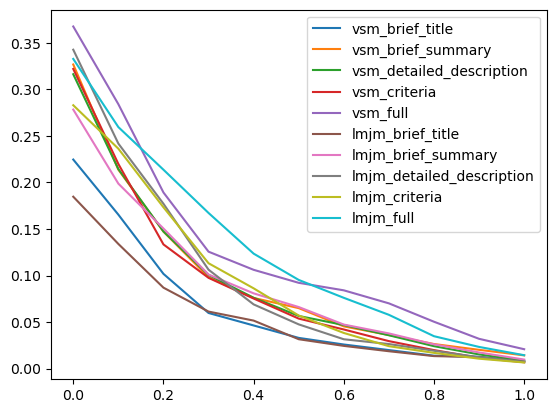

In [8]:
recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for index_name in indexes_list:
    if index_name in indexes:
        index = indexes_list[index_name]
        plt.plot(recall_11point,index.mean_precision_11point, label = index_name)
        plt.legend()

plt.show()

In [9]:
results_table = pd.DataFrame(columns =['model', 'p10', 'ndcg5', 'mrr', 'map', 'recall'])
for index_name in indexes_list:
    if index_name in indexes:
        index = indexes_list[index_name]
        aa = pd.DataFrame({'model':[index_name], 'p10':[index.m_p10], 'ndcg5':[index.m_ndcg5], 'mrr': [index.m_mrr], 'map':[index.m_ap], 'recall':[index.m_recall]})
        results_table = results_table._append(aa, ignore_index=False)

results_table

,model,p10,ndcg5,mrr,map,recall
0,vsm_brief_title,0.071186,0.064055,0.224646,0.051050,1.0
0,vsm_brief_summary,0.098305,0.120090,0.326781,0.078413,1.0
0,vsm_detailed_description,0.122034,0.119872,0.316304,0.076191,1.0
0,vsm_criteria,0.111864,0.135754,0.321985,0.074324,1.0
0,vsm_full,0.135593,0.143452,0.367623,0.108157,1.0
0,lmjm_brief_title,0.067797,0.055938,0.184726,0.047118,1.0
0,lmjm_brief_summary,0.111864,0.112088,0.278336,0.076736,1.0
0,lmjm_detailed_description,0.120339,0.120531,0.342663,0.076709,1.0
0,lmjm_criteria,0.118644,0.124997,0.283001,0.077923,1.0
0,lmjm_full,0.172881,0.136041,0.332764,0.108977,1.0


LETOR

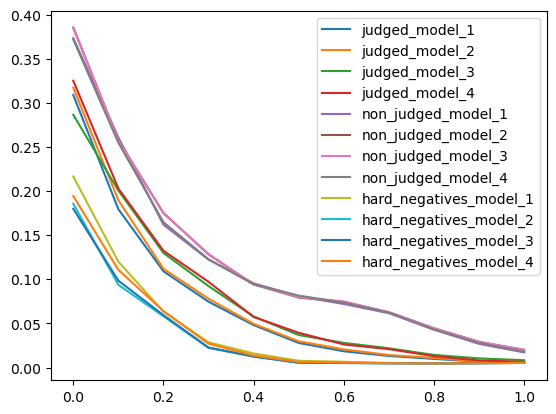

In [10]:
recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for index_name in indexes_list:
    if index_name not in indexes:
        index = indexes_list[index_name]
        plt.plot(recall_11point,index.mean_precision_11point, label = index_name)
        plt.legend()

plt.show()

In [11]:
results_table = pd.DataFrame(columns =['model', 'p10', 'ndcg5', 'mrr', 'map', 'recall'])

for index_name in indexes_list:
    if index_name not in indexes:
        index = indexes_list[index_name]
        aa = pd.DataFrame({'model':[index_name], 'p10':[index.m_p10], 'ndcg5':[index.m_ndcg5], 'mrr': [index.m_mrr], 'map':[index.m_ap], 'recall':[index.m_recall]})
        results_table = results_table._append(aa, ignore_index=False)

results_table

,model,p10,ndcg5,mrr,map,recall
0,judged_model_1,0.105085,0.117130,0.309148,0.055611,1.0
0,judged_model_2,0.106780,0.118213,0.317463,0.058244,1.0
0,judged_model_3,0.120339,0.114221,0.286704,0.064448,1.0
0,judged_model_4,0.103390,0.124091,0.325308,0.066209,1.0
0,non_judged_model_1,0.132203,0.147292,0.373596,0.099305,1.0
0,non_judged_model_2,0.125424,0.142241,0.385730,0.101009,1.0
0,non_judged_model_3,0.125424,0.142241,0.385261,0.101085,1.0
0,non_judged_model_4,0.125424,0.142910,0.372171,0.099339,1.0
0,hard_negatives_model_1,0.047458,0.068911,0.216774,0.028224,1.0
0,hard_negatives_model_2,0.040678,0.055746,0.185826,0.023755,1.0


------------------------------

In [ ]:
# ORIGINAL CELL MADE BY THE TEACHER
index = indexes_list['lmjm_full']
#index = indexes_list['lmjm_brief_title']

query_result = np.sort([index.p10_per_query[caseid] for caseid in cases])
query_text = np.sort([cases[caseid][0:30] for caseid in cases])

#queries_at_indices = [query_text[::-1][i] for i in range(0, len(query_text), 6)]
#print(queries_at_indices)

figure(figsize=(8, 19), dpi=80)

plt.barh(query_text, query_result)

In [49]:
metrics = ['p10', 'ndcg5', 'recall', 'mrr', 'ap']

def get_query_result(selected_index, selected_metric):
    query_result = None
    
    if selected_metric == metrics[0]:
        query_result = np.sort([indexes_list[selected_index].p10_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[1]:
        query_result = np.sort([indexes_list[selected_index].ndcg5_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[2]:
        query_result = np.sort([indexes_list[selected_index].recall_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[3]:
        query_result = np.sort([indexes_list[selected_index].mrr_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[4]:
        query_result = np.sort([indexes_list[selected_index].ap_per_query[caseid] for caseid in cases])
        
    return query_result
    

In [ ]:
# CELL CREATED TO VISUALIZE THE METRICS OF EACH MODEL INDIVIDUALLY WITH EASE

query_texts = np.sort([cases[caseid][0:30] for caseid in cases])

def plot_barh(selected_index, selected_metric):
    plt.figure(figsize=(8, 19), dpi=80)
    
    query_result = get_query_result(selected_index, selected_metric)
        
    y = np.arange(len(query_result))
    
    figure(figsize=(8, 19), dpi=80)

    plt.barh(query_texts, query_result)


index_selector = Dropdown(options=list(indexes_list.keys()))
metric_selector = Dropdown(options=metrics)

interact(plot_barh, selected_index=index_selector, selected_metric = metric_selector)

In [ ]:
# CELL CREATED TO VISUALIZE THE METRICS OF ALL MODELS AT ONCE (MIGHT NEED CHANGING SO MARKERS IN THE CHART DONT OVERLAP)
import plotly.express as px
query_texts = np.sort([cases[caseid][0:30] for caseid in cases])

# Define a function to update the scatter plot
def update_scatter(selected_metric):
    data = []

    for key in indexes_list:
        query_result = get_query_result(key, selected_metric)
        data.extend([(query_result[i], query_texts[i], key) for i in range(len(query_result))])

    df = pd.DataFrame(data, columns=[selected_metric, "Cases", "Model"])

    fig = px.scatter(
        df,
        x=selected_metric,
        y="Cases",
        color="Model",
        title=f"Scatter Plot of {selected_metric}"
    )
    
    fig.update_layout(
        height=1000,
        width=1000,  
    )
    

    fig.show()

# Create a dropdown menu for selecting metrics
metric_selector = Dropdown(options=metrics)

# Use the interact function to update the scatter plot based on the selected metric
interact(update_scatter, selected_metric=metric_selector)

Training and Performance Evaluation

judged model 1 Performance
Accuracy: 0.7025
Precision: 0.0000
Recall: 0.0000
MSE: 0.2975


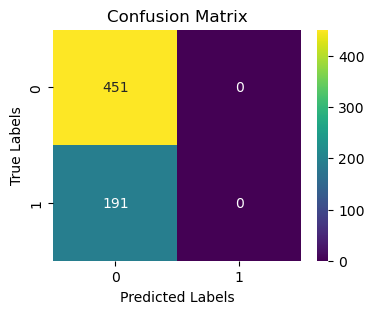


------------------------------

judged model 2 Performance
Accuracy: 0.4611
Precision: 0.2540
Recall: 0.4188
MSE: 0.5389


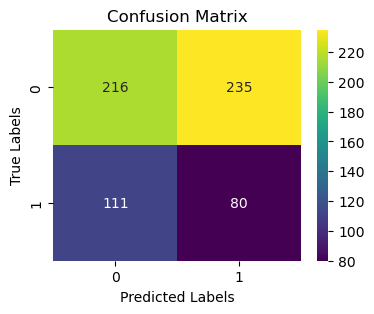


------------------------------

judged model 3 Performance
Accuracy: 0.4423
Precision: 0.4402
Recall: 0.4661
MSE: 0.5577


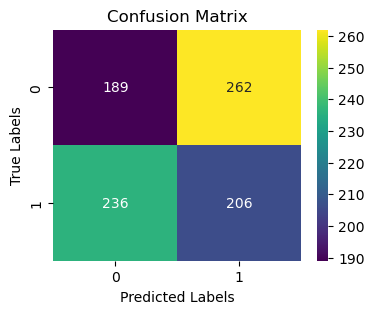


------------------------------

judged model 4 Performance
Accuracy: 0.4143
Precision: 0.3061
Recall: 0.7644
MSE: 0.5857


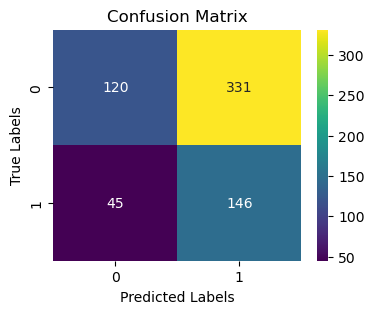


------------------------------

non_judged model 1 Performance
Accuracy: 0.9944
Precision: 0.1765
Recall: 0.0157
MSE: 0.0056


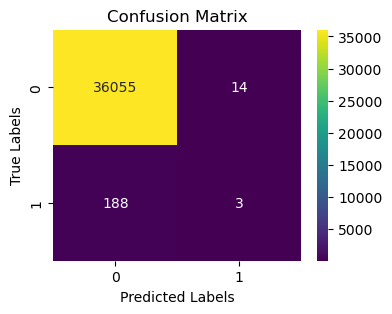


------------------------------

non_judged model 2 Performance
Accuracy: 0.8807
Precision: 0.0193
Recall: 0.4346
MSE: 0.1193


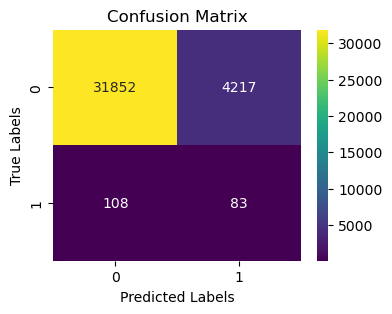


------------------------------

non_judged model 3 Performance
Accuracy: 0.6671
Precision: 0.7550
Recall: 0.4808
MSE: 0.3329


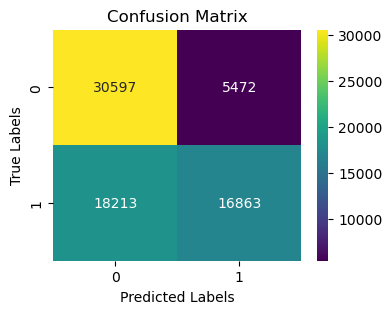


------------------------------

non_judged model 4 Performance
Accuracy: 0.9825
Precision: 0.0664
Recall: 0.1780
MSE: 0.0175


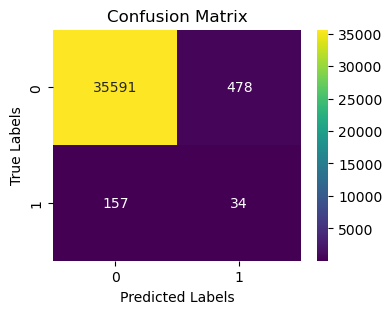


------------------------------

hard_negatives model 1 Performance
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
MSE: 0.0000


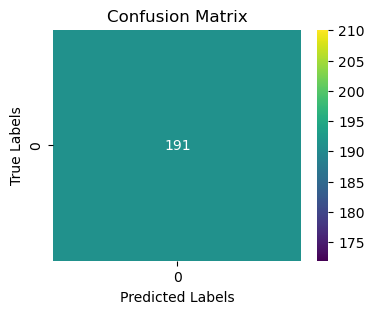


------------------------------

hard_negatives model 2 Performance
Accuracy: 0.9948
Precision: 1.0000
Recall: 0.9948
MSE: 0.0052


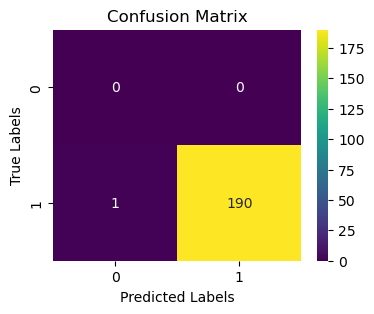


------------------------------

hard_negatives model 3 Performance
Accuracy: 0.8325
Precision: 1.0000
Recall: 0.8325
MSE: 0.1675


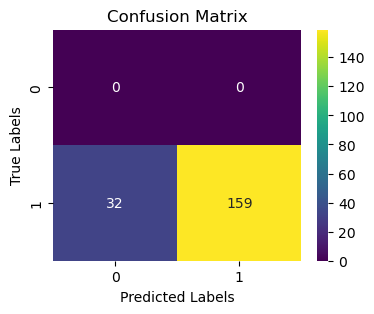


------------------------------

hard_negatives model 4 Performance
Accuracy: 0.9529
Precision: 1.0000
Recall: 0.9529
MSE: 0.0471


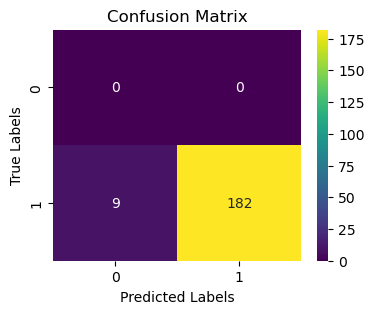


------------------------------



In [14]:
#index = indexes_list["hard_negatives_model_4"]

for index in indexes_list:
    if index not in indexes:
        model = indexes_list[index]
        print(f"{model.name} model {model.model_number} Performance")
        model.show_model_metrics()
        print()
        print("------------------------------")
        print()

Coefficients

In [30]:
column_names = ['model', 
            'vsm_brief_title',
            'vsm_brief_summary',
            'vsm_detailed_description',
            'vsm_criteria',
            'lmjm_brief_title',
            'lmjm_brief_summary',
            'lmjm_detailed_description',
            'lmjm_criteria']

results_table = pd.DataFrame(columns=column_names)

for index_name in indexes_list:
    if index_name not in indexes:
        coefs = indexes_list[index_name].model.coef_[0]
        column_values = [index_name]
        column_values.extend(coefs.tolist())  # Add elements from coefs to column_values

        print(column_values)
        aa = pd.DataFrame([column_values], columns=column_names)
        results_table = results_table._append(aa, ignore_index=False)

results_table

['judged_model_1', 0.03387434153303997, -0.06521411176875351, 0.01714411730353659, 0.05883426094736666, 0.1710270389020551, 0.3025545386090483, -0.5777283083861008, 0.1338895184930598]
['judged_model_2', 0.03272675477318016, -0.0607806231450759, 0.019850073777317713, 0.05666110049923323, 0.18145305185154548, 0.29511718490970157, -0.5758452677987691, 0.13805342333352164]
['judged_model_3', 0.033484392722981905, -0.07803368084865568, 0.05845853839055306, 0.07107044577803731, 0.2089043923832167, 0.3271914882315333, -0.6719265966604022, 0.16847988986181256]
['judged_model_4', 0.015355859638843115, -0.05467208270739459, 0.024888463799537585, 0.08652450902643728, 0.2173073955842088, 0.23678857438296066, -0.43350207285491893, 0.04161404597403916]
['non_judged_model_1', 0.012309100810504618, 0.11540842926910017, 0.17078661753980157, 0.2771684021855356, 0.331497368226981, 0.27807394185616197, -0.1426421690993771, -0.36907968183383033]
['non_judged_model_2', 0.057899404132378596, 0.2130476135006

,model,vsm_brief_title,vsm_brief_summary,vsm_detailed_description,vsm_criteria,lmjm_brief_title,lmjm_brief_summary,lmjm_detailed_description,lmjm_criteria
0,judged_model_1,0.033874,-0.065214,0.017144,0.058834,0.171027,0.302555,-0.577728,0.133890
0,judged_model_2,0.032727,-0.060781,0.019850,0.056661,0.181453,0.295117,-0.575845,0.138053
0,judged_model_3,0.033484,-0.078034,0.058459,0.071070,0.208904,0.327191,-0.671927,0.168480
0,judged_model_4,0.015356,-0.054672,0.024888,0.086525,0.217307,0.236789,-0.433502,0.041614
0,non_judged_model_1,0.012309,0.115408,0.170787,0.277168,0.331497,0.278074,-0.142642,-0.369080
0,non_judged_model_2,0.057899,0.213048,0.300714,0.351210,0.442707,0.653659,-0.152240,-0.793862
0,non_judged_model_3,0.111813,0.555647,0.854389,0.850956,0.474538,0.591015,-0.120448,-0.800352
0,non_judged_model_4,0.049791,0.226437,0.325773,0.337160,0.526565,0.691682,-0.112459,-0.921659
0,hard_negatives_model_1,-0.003846,-0.148359,0.037478,-0.235780,-2.975859,0.441753,3.157694,-0.758547
0,hard_negatives_model_2,0.072192,-0.248577,-0.035000,-0.447688,-4.433621,0.801408,4.783404,-1.414680
